# Ablauf

1) Daten einlesen
2) Daten aufebereiten
    -   Ausreißer identifizieren
3) GSMP-Kenndaten aufbereiten
4) Analyse
    -   Scatterplot Jobs auf Watt + Regression
    -   line chart auf bar chart
    -   Berechnung pro Worker - Idle

# 0. Helfer-Funktionen

In [1]:
def filter_outliers_iqr_per_column(column, multiplier=1.5):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    outliers = ((column < lower_bound) | (column > upper_bound))
    return column[~outliers]

# Function to apply the IQR method for each row in a DataFrame
def filter_outliers_iqr(df, multiplier=1.5):
    return df.apply(filter_outliers_iqr_per_column, axis=0).apply(pd.to_numeric, errors='coerce')


# 1. Daten einlesen

### CSV einlesen

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats.mstats import winsorize

#read Worker Power CSV
worker_power = pd.read_csv("CSV-mja/2024-02-18 20-30-00 power all pods.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read zeebe Power CSV
zeebe_power = pd.read_csv("CSV-mja/2024-02-18 20-30-00 power all pods.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Finished CSV
worker_jobs_finished = pd.read_csv("CSV-mja/2024-02-18 20-30-00 worker jobs finished.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Started CSV
worker_jobs_started = pd.read_csv("CSV-mja/2024-02-18 20-30-00 worker jobs started.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe gRPC CSV
zeebe_grpc = pd.read_csv("CSV-mja/2024-02-18 20-30-00 zeebe grpc.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Creation CSV
zeebe_job_creation = pd.read_csv("CSV-mja/2024-02-18 20-30-00 zeebe job creation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labelsww

#read Zeebe Job Completion CSV
zeebe_job_completion = pd.read_csv("CSV-mja/2024-02-18 20-30-00 zeebe job completion.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Completion CSV
zeebe_latency_extension = pd.read_csv("CSV-mja/2024-02-18 20-30-00 zeebe grpc latency.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

zeebe_grpc


,CompleteJob (NOT_FOUND),ActivateJobs (OK),CompleteJob (OK),CreateProcessInstance (OK),DeployResource (OK),FailJob (OK),Topology (OK),ActivateJobs (RESOURCE_EXHAUSTED),CreateProcessInstance (RESOURCE_EXHAUSTED),Total requests completed
Time,,,,,,,,,,
2024-02-18 20:30:00,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.01820
2024-02-18 20:30:10,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.00909
2024-02-18 20:30:20,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.00909
2024-02-18 20:30:30,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.00909
2024-02-18 20:30:40,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.00909
...,...,...,...,...,...,...,...,...,...,...
2024-02-19 04:59:20,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.01820
2024-02-19 04:59:30,0.0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.00909
2024-02-19 04:59:40,0.0,0.1,0.0,0.0,0,0,0,0.0,0.0,0.01820


#### Erweiterung Messreihen

In [3]:
#read Worker Power CSV
worker_power_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 worker power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read zeebe Power CSV
zeebe_power_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 zeebe power.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Finished CSV
worker_jobs_finished_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 worker jobs finished.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Worker: Jobs Started CSV
worker_jobs_started_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 worker jobs started.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe gRPC CSV
zeebe_grpc_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 zeebe grpc.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Creation CSV
zeebe_job_creation_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 zeebe job creation.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Completion CSV
zeebe_job_completion_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 zeebe job completion.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

#read Zeebe Job Completion CSV
zeebe_latency_extension = pd.read_csv("CSV-mja/2024-02-17 22-50-00 zeebe grpc latency.csv", 
                     header=1, # which row contains column headers
                     index_col=0   ) # which column contains labels

**Log-Datei einlesen**

In [4]:
LOG_PATH = "shell-scripts/logs/mja/"
LOG_NAME = "mja2.sh-2024-02-18-20-30-00-load_generator_8x90_parallel" # mja 8,64,512

LOG_NAME_EXT = "mja2.sh-2024-02-17-22-50-00-load_generator_8x90_parallel" # mja 1, 2, 1536

# read all 3 log file of START times

def read_start_times(LOG_PATH = LOG_PATH,LOG_NAME = LOG_NAME):
    start_times = []
    settings= []

    with open(LOG_PATH+LOG_NAME, "r") as file:
        log_lines = file.readlines()

    # remove newline-character, 
    for i, time in enumerate(log_lines):
        line = time.split()

        #append and remove dash between time and date to match index of CSVs
        start_times.append(line[0][:10] + " " + line[0][11:])

    return start_times, settings

start_times_base, settings = read_start_times()
start_times_extended, settings_extended = read_start_times(LOG_PATH, LOG_NAME_EXT)

start_times_extended

['2024-02-17 22:52:00',
 '2024-02-17 22:54:00',
 '2024-02-17 22:56:00',
 '2024-02-17 22:58:00',
 '2024-02-17 23:00:00',
 '2024-02-17 23:02:00',
 '2024-02-17 23:04:00',
 '2024-02-17 23:06:00',
 '2024-02-17 23:08:10',
 '2024-02-17 23:10:10',
 '2024-02-17 23:12:10',
 '2024-02-17 23:14:10',
 '2024-02-17 23:16:10',
 '2024-02-17 23:18:50',
 '2024-02-17 23:20:50',
 '2024-02-17 23:22:50',
 '2024-02-17 23:24:50',
 '2024-02-17 23:26:50',
 '2024-02-17 23:28:50',
 '2024-02-17 23:30:50',
 '2024-02-17 23:38:00',
 '2024-02-17 23:40:00',
 '2024-02-17 23:42:00',
 '2024-02-17 23:44:10',
 '2024-02-17 23:46:10',
 '2024-02-17 23:48:10',
 '2024-02-17 23:50:10',
 '2024-02-17 23:52:20',
 '2024-02-17 23:54:20',
 '2024-02-17 23:56:20',
 '2024-02-17 23:58:30',
 '2024-02-18 00:00:30',
 '2024-02-18 00:02:30',
 '2024-02-18 00:04:40',
 '2024-02-18 00:06:40',
 '2024-02-18 00:08:40',
 '2024-02-18 00:10:50',
 '2024-02-18 00:12:50',
 '2024-02-18 00:14:50',
 '2024-02-18 00:17:00',
 '2024-02-18 00:24:00',
 '2024-02-18 00:

#### Verbinde start_times base und extended

In [5]:
start_times = start_times_base.copy()

for  i in start_times_extended:
    start_times.append(i)

start_times

['2024-02-18 20:32:00',
 '2024-02-18 20:34:00',
 '2024-02-18 20:36:00',
 '2024-02-18 20:38:00',
 '2024-02-18 20:40:00',
 '2024-02-18 20:42:00',
 '2024-02-18 20:44:10',
 '2024-02-18 20:46:10',
 '2024-02-18 20:48:10',
 '2024-02-18 20:50:10',
 '2024-02-18 20:52:10',
 '2024-02-18 20:54:10',
 '2024-02-18 20:56:10',
 '2024-02-18 20:58:10',
 '2024-02-18 21:00:20',
 '2024-02-18 21:02:20',
 '2024-02-18 21:04:20',
 '2024-02-18 21:06:20',
 '2024-02-18 21:08:20',
 '2024-02-18 21:10:20',
 '2024-02-18 21:17:20',
 '2024-02-18 21:19:20',
 '2024-02-18 21:21:30',
 '2024-02-18 21:23:30',
 '2024-02-18 21:25:30',
 '2024-02-18 21:27:40',
 '2024-02-18 21:29:40',
 '2024-02-18 21:31:40',
 '2024-02-18 21:33:50',
 '2024-02-18 21:35:50',
 '2024-02-18 21:37:50',
 '2024-02-18 21:39:50',
 '2024-02-18 21:42:00',
 '2024-02-18 21:44:00',
 '2024-02-18 21:46:00',
 '2024-02-18 21:48:10',
 '2024-02-18 21:50:10',
 '2024-02-18 21:52:10',
 '2024-02-18 21:54:20',
 '2024-02-18 21:56:20',
 '2024-02-18 22:03:20',
 '2024-02-18 22:

# 2. Daten aufbereiten

1) Addiere alle Messwerte von Kepler
2) Generiere Leerlauf-Muster
3) Subtrahiere Leerlauf-Muster

4) Vereine Completion und Power
5) Generiere Durchsatz-Buckets
6) Berechne Outlier pro Bucket

### Messwerte aus Kepler einlesen und summieren

#### Base

In [6]:
completion_and_power_base = pd.DataFrame()

worker_cols = [col for col in worker_power.columns if 'restworkerjava' in col ]
zeebe_cols = [col for col in zeebe_power.columns if 'zeebe' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power_base['worker_power'] = worker_power[worker_cols].sum(axis=1)
completion_and_power_base['zeebe_power'] = zeebe_power[zeebe_cols].sum(axis=1)

#### Extension

In [7]:
completion_and_power_extension = pd.DataFrame()

worker_cols = [col for col in worker_power_extension.columns if 'restworkerjava' in col ]
zeebe_cols = [col for col in zeebe_power_extension.columns if 'zeebe' in col ]

# sum up PKG + DRAM + OTHER for each time stamp
completion_and_power_extension['worker_power'] = worker_power_extension[worker_cols].sum(axis=1)
completion_and_power_extension['zeebe_power'] = zeebe_power_extension[zeebe_cols].sum(axis=1)

### Durchsatzwerte aus Worker, Zeebe und gRPC einlesen

#### Base

In [8]:
completion_and_power_base['jobs_started'] = worker_jobs_started['worker'] // 1
completion_and_power_base['jobs_finished'] = worker_jobs_finished['worker'] // 1
completion_and_power_base['jobs_open'] = completion_and_power_base['jobs_started'] - completion_and_power_base['jobs_finished']
completion_and_power_base['grpc_activation_ok'] = zeebe_grpc['ActivateJobs (OK)']
completion_and_power_base['grpc_activation_exhausted'] = zeebe_grpc['ActivateJobs (RESOURCE_EXHAUSTED)']
completion_and_power_base['grpc_activation_total'] = completion_and_power_base['grpc_activation_ok'] + completion_and_power_base['grpc_activation_exhausted']
completion_and_power_base['grpc_completion_ok'] = zeebe_grpc['CompleteJob (OK)']
completion_and_power_base['zeebe_job_creation'] = zeebe_job_creation['Job creation camunda8']
completion_and_power_base['zeebe_job_completion'] = zeebe_job_completion['Job completion camunda8']


#### Extension

In [9]:
completion_and_power_extension['jobs_started'] = worker_jobs_started_extension['worker'] // 1
completion_and_power_extension['jobs_finished'] = worker_jobs_finished_extension['worker'] // 1
completion_and_power_extension['jobs_open'] = completion_and_power_extension['jobs_started'] - completion_and_power_extension['jobs_finished']
completion_and_power_extension['grpc_activation_ok'] = zeebe_grpc_extension['ActivateJobs (OK)']
completion_and_power_extension['grpc_activation_exhausted'] = zeebe_grpc_extension['ActivateJobs (RESOURCE_EXHAUSTED)']
completion_and_power_extension['grpc_activation_total'] = completion_and_power_extension['grpc_activation_ok'] + completion_and_power_extension['grpc_activation_exhausted']
completion_and_power_extension['grpc_completion_ok'] = zeebe_grpc_extension['CompleteJob (OK)']
completion_and_power_extension['zeebe_job_creation'] = zeebe_job_creation_extension['Job creation camunda8']
completion_and_power_extension['zeebe_job_completion'] = zeebe_job_completion_extension['Job completion camunda8']

### Generiere Leerlauf-Muster + Subtrahiere Leerlauf-Muster

In [10]:
def create_idle_pattern(df, column, job_start_col, job_finished_col):
    # set all completion >= 1 to NaN

    idle_power = df.copy()
    idle_power[(idle_power[job_start_col] >= 1) & (idle_power[job_finished_col] >= 1)] = np.nan


    # generate medians for 00:00, 00:10, 00:20
    

    # reshape series
    idle_pattern = pd.DataFrame(idle_power[column][:-1].to_numpy().reshape(-1, 3), columns=['00:00', '00:10', '00:20'])
    idle_pattern = filter_outliers_iqr(idle_pattern)

    medians = idle_pattern.median(axis=0)

    return medians

# Base
worker_idle_medians_base = create_idle_pattern(completion_and_power_base, 'worker_power', 'jobs_started', 'jobs_finished')
zeebe_idle_medians_base = create_idle_pattern(completion_and_power_base, 'zeebe_power', 'zeebe_job_creation', 'zeebe_job_completion')

# Extension
worker_idle_medians_extension = create_idle_pattern(completion_and_power_extension, 'worker_power', 'jobs_started', 'jobs_finished')
zeebe_idle_medians_extension = create_idle_pattern(completion_and_power_extension, 'zeebe_power', 'zeebe_job_creation', 'zeebe_job_completion')


In [11]:
def remove_idle_power(df, pattern, column):
    pattern_series = pd.Series()
    
    difference = 0
    
    # repeat the pattern until length of df.index is reached
    while len(pattern_series) < len(df.index):
        pattern_series = pd.concat([pattern_series, pattern])
        difference = len(pattern_series) - len(df.index)

    pattern_series = pattern_series[:-difference]
    pattern_series.index = df.index

    pattern_series = pattern_series.apply(pd.to_numeric, errors='coerce')

    df[f"{column}_no_idle"] = df[column] - pattern_series
    df[f"{column}_idle"] = pattern_series


    return df

# Base
cap_no_idle_base = remove_idle_power(completion_and_power_base, worker_idle_medians_base, "worker_power")
cap_no_idle_base = remove_idle_power(completion_and_power_base, zeebe_idle_medians_base, "zeebe_power")

# Extension
cap_no_idle_extension = remove_idle_power(completion_and_power_extension, worker_idle_medians_extension, "worker_power")
cap_no_idle_extension = remove_idle_power(completion_and_power_extension, zeebe_idle_medians_extension, "zeebe_power")

### Vereine Base und Extension

In [12]:
cap_no_idle = pd.concat([cap_no_idle_base,cap_no_idle_extension], axis=0)


### Generiere Energieverbrauch pro Job

In [13]:
cap_no_idle['worker_power_per_job_no_idle'] = cap_no_idle['worker_power_no_idle'] / cap_no_idle['jobs_started']
cap_no_idle['zeebe_power_per_job_no_idle'] = cap_no_idle['zeebe_power_no_idle'] / cap_no_idle['jobs_started']

### Teile Messreihen nach Konfiguration


#### Base

In [14]:

START_MJA8 = start_times_base[0]


end_mja8_index = cap_no_idle.index.get_loc(start_times_base[60])
END_MJA8 = cap_no_idle.index[end_mja8_index]

START_MJA64 = start_times_base[60]
end_mja64_index = cap_no_idle.index.get_loc(start_times_base[120])
END_MJA64 = cap_no_idle.index[end_mja64_index]

START_MJA512 = start_times_base[120]

# use last index of base measurement CSV
END_MJA512 = worker_power.index[-1]

data_8 = cap_no_idle.loc[START_MJA8:END_MJA8,:]
data_64 = cap_no_idle.loc[START_MJA64:END_MJA64,:]
data_512 = cap_no_idle.loc[START_MJA512:END_MJA512,:]

#### Extension

In [15]:
START_MJA1 = start_times_extended[0]
# before first entry of mja64, there was 1 min of waiting for new worker and 5 minutes of cooloff - so 360 seconds -> 36 entries in index
end_mja1_index = cap_no_idle.index.get_loc(start_times_extended[60])
END_MJA1 = cap_no_idle.index[end_mja1_index]

START_MJA2 = start_times_extended[60]
end_mja2_index = cap_no_idle.index.get_loc(start_times_extended[120])
END_MJA2 = cap_no_idle.index[end_mja2_index]

START_MJA1536 = start_times_extended[120]

#use last index of extended measurement CSV
END_MJA1536 = worker_power_extension.index[-1]

data_1 = cap_no_idle.loc[START_MJA1:END_MJA1,:]
data_2 = cap_no_idle.loc[START_MJA2:END_MJA2,:]
data_1536 = cap_no_idle.loc[START_MJA1536:END_MJA1536,:]

<Axes: xlabel='Time'>

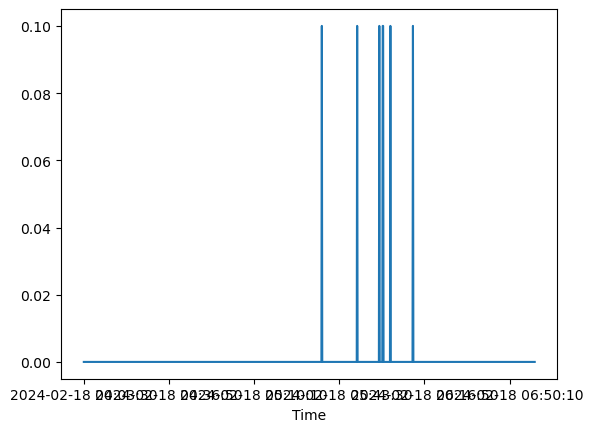

In [16]:
data_1536['grpc_activation_exhausted'].plot()

### Entferne Zeitpunkte ohne Durchsatz

==Temporär entfernt, interessant für Durchsatz-Buckets, nicht für Summen==

In [17]:
# cap_no_idle = cap_no_idle[(cap_no_idle['jobs_started'] >= 1) & (cap_no_idle['jobs_finished'] >= 1)]

# Ansatz 1: Sortieren nach Durchsatz

### Sortiere nach Durchsatz

In [18]:
THROUGHPUT_COLUMN = 'grpc_completion_ok'

sorted_1 = data_1.sort_values(by=THROUGHPUT_COLUMN)
sorted_2 = data_2.sort_values(by=THROUGHPUT_COLUMN)
sorted_8 = data_8.sort_values(by=THROUGHPUT_COLUMN)
sorted_64 = data_64.sort_values(by=THROUGHPUT_COLUMN)
sorted_512 = data_512.sort_values(by=THROUGHPUT_COLUMN)
sorted_1536 = data_1536.sort_values(by=THROUGHPUT_COLUMN)
all_sorted = cap_no_idle.sort_values(by=THROUGHPUT_COLUMN)


### Generiere Durchsatz-Buckets pro Job


In [19]:
# Bucket Params
BUCKET_WIDTH = 10

def create_buckets(df, col, bucket_width):

    # create limits for buckets
    max_throughput = int(df[col].max())
    min_throughput = int(df[col].min())
    span_throughput = int(max_throughput - min_throughput)

    # number of buckets
    num_buckets = (span_throughput // bucket_width) + 1

    buckets = [i for i in range(min_throughput ,max_throughput + bucket_width, bucket_width)]
    bucket_labels = [f"{buckets[i]} - {buckets[i+1]}" for i in range(len(buckets) - 1)]

    return buckets, bucket_labels


buckets, bucket_labels = create_buckets(all_sorted, THROUGHPUT_COLUMN, BUCKET_WIDTH)



### Sortiere nach Buckets

In [20]:
def group_by_bucket(sorted_df, groupby, grouped_col, bucket_list):
    df_grouped = pd.DataFrame()

    grouped_list = [sorted_df[
            (sorted_df[groupby] >= bucket_list[i]) 
            & 
            (sorted_df[groupby] < bucket_list[i + 1])
            ]
            [grouped_col]
            .reset_index(drop=True) 
            for i in range(len(bucket_list) - 1)]

    temp = pd.concat(grouped_list, axis=1)

    temp.columns = bucket_list[0:len(bucket_list) - 1]

    return temp

**worker**

In [21]:
grouped_1 = group_by_bucket(sorted_1, THROUGHPUT_COLUMN, 'worker_power_no_idle', buckets)
grouped_2 = group_by_bucket(sorted_2, THROUGHPUT_COLUMN, 'worker_power_no_idle', buckets)
grouped_8 = group_by_bucket(sorted_8, THROUGHPUT_COLUMN, 'worker_power_no_idle', buckets)
grouped_64 = group_by_bucket(sorted_64, THROUGHPUT_COLUMN, 'worker_power_no_idle', buckets)
grouped_512 = group_by_bucket(sorted_512, THROUGHPUT_COLUMN, 'worker_power_no_idle', buckets)
grouped_1536 = group_by_bucket(sorted_1536, THROUGHPUT_COLUMN, 'worker_power_no_idle', buckets)

**zeebe**

In [22]:
grouped_1_zeebe = group_by_bucket(sorted_1, THROUGHPUT_COLUMN, 'zeebe_power_no_idle', buckets)
grouped_2_zeebe = group_by_bucket(sorted_2, THROUGHPUT_COLUMN, 'zeebe_power_no_idle', buckets)
grouped_8_zeebe = group_by_bucket(sorted_8, THROUGHPUT_COLUMN, 'zeebe_power_no_idle', buckets)
grouped_64_zeebe = group_by_bucket(sorted_64, THROUGHPUT_COLUMN, 'zeebe_power_no_idle', buckets)
grouped_512_zeebe = group_by_bucket(sorted_512, THROUGHPUT_COLUMN, 'zeebe_power_no_idle', buckets)
grouped_1536_zeebe = group_by_bucket(sorted_2, THROUGHPUT_COLUMN, 'zeebe_power_no_idle', buckets)

### Entferne Ausreißer

**worker**

In [23]:
clean_1 = filter_outliers_iqr(grouped_1)
clean_2 = filter_outliers_iqr(grouped_2)
clean_8 = filter_outliers_iqr(grouped_8)
clean_64 = filter_outliers_iqr(grouped_64)
clean_512 = filter_outliers_iqr(grouped_512)
clean_1536 = filter_outliers_iqr(grouped_1536)

**zeebe**

In [24]:
clean_1_zeebe = filter_outliers_iqr(grouped_1_zeebe)
clean_2_zeebe = filter_outliers_iqr(grouped_2_zeebe)
clean_8_zeebe = filter_outliers_iqr(grouped_8_zeebe)
clean_64_zeebe = filter_outliers_iqr(grouped_64_zeebe)
clean_512_zeebe = filter_outliers_iqr(grouped_512_zeebe)
clean_1536_zeebe = filter_outliers_iqr(grouped_1536_zeebe)

#### Entferne Buckets mit weniger als X Einträgen

In [25]:
BUCKET_MINIMUM = 10

clean_1 = clean_1.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_2 = clean_2.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_8 = clean_8.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_64 = clean_64.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_512 = clean_512.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_1536 = clean_1536.dropna(axis=1, thresh=BUCKET_MINIMUM)

clean_1_zeebe = clean_1_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_2_zeebe = clean_2_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_8_zeebe = clean_8_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_64_zeebe = clean_64_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_512_zeebe = clean_512_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)
clean_1536_zeebe = clean_1536_zeebe.dropna(axis=1, thresh=BUCKET_MINIMUM)



In [26]:
lmh_hist = pd.DataFrame()

lmh_hist['mja1'] = clean_1.count()
lmh_hist['mja2'] = clean_2.count()
lmh_hist['mja8'] = clean_8.count()
lmh_hist['mja64'] = clean_64.count()
lmh_hist['mja512'] = clean_512.count()
lmh_hist['mja1536'] = clean_1536.count()

lmh_hist = lmh_hist.dropna(axis=0, thresh=2)

<Axes: title={'center': 'Size of Buckets'}>

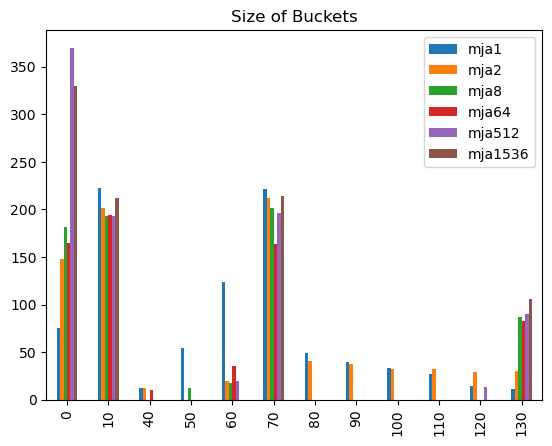

In [27]:
lmh_hist.plot(kind='bar', title='Size of Buckets')

In [28]:
lmh_hist

,mja1,mja2,mja8,mja64,mja512,mja1536
0,75,148.0,181.0,165.0,370.0,330.0
10,222,201.0,193.0,194.0,193.0,212.0
40,12,12.0,NaN,10.0,NaN,NaN
50,54,NaN,12.0,NaN,NaN,NaN
60,124,20.0,18.0,35.0,20.0,NaN
70,221,212.0,201.0,164.0,196.0,214.0
80,49,41.0,NaN,NaN,NaN,NaN
90,40,37.0,NaN,NaN,NaN,NaN
100,33,32.0,NaN,NaN,NaN,NaN
110,27,32.0,NaN,NaN,NaN,NaN


### Erstelle Vergleichstabelle
Mediane nach Durchsatz sortiert

**worker**

In [29]:
hml_median = pd.DataFrame()
hml_median['mja1'] = clean_1.median()
hml_median['mja2'] = clean_2.median()
hml_median['mja8'] = clean_8.median()
hml_median['mja64'] = clean_64.median()
hml_median['mja512'] = clean_512.median()
hml_median['mja1536'] = clean_1536.median()

**zeebe**

In [30]:
hml_median_zeebe = pd.DataFrame()
hml_median_zeebe['mja1'] = clean_1_zeebe.median()
hml_median_zeebe['mja2'] = clean_2_zeebe.median()
hml_median_zeebe['mja8'] = clean_8_zeebe.median()
hml_median_zeebe['mja64'] = clean_64_zeebe.median()
hml_median_zeebe['mja512'] = clean_512_zeebe.median()
hml_median_zeebe['mja1536'] = clean_1536_zeebe.median()

# Plotting

In [31]:
# PLOT SETTINGS

figsize = [9,8]
whis= [0,100]

# LABELS

labels = {
    'power' : 'Energieverbrauch in Watt pro Sekunde',
    'throughput' : 'Jobs pro Sekunde'
}




<Axes: title={'center': 'Energieverbrauch nach Durchsatz im Median (Zeebe)'}, xlabel='Jobs pro Sekunde', ylabel='Energieverbrauch in Watt pro Sekunde'>

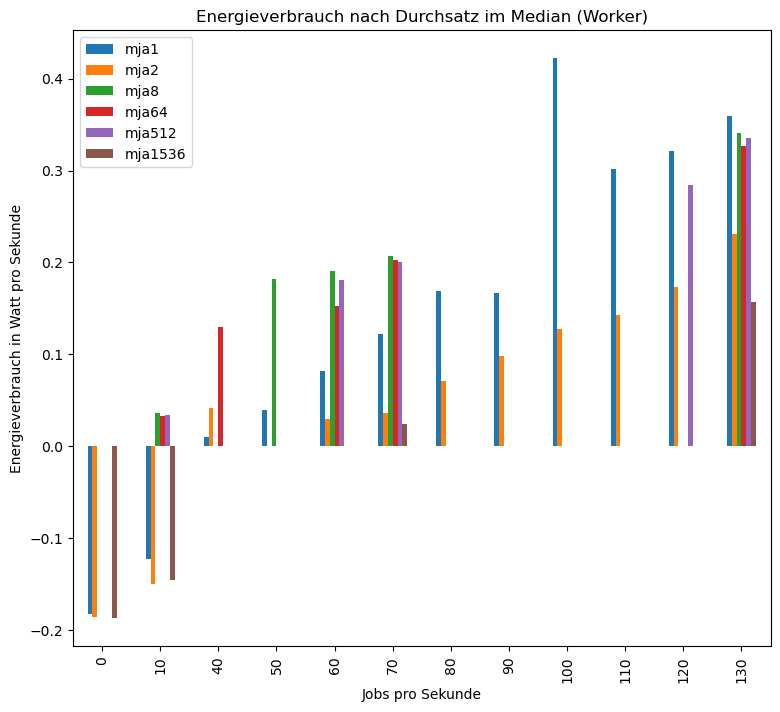

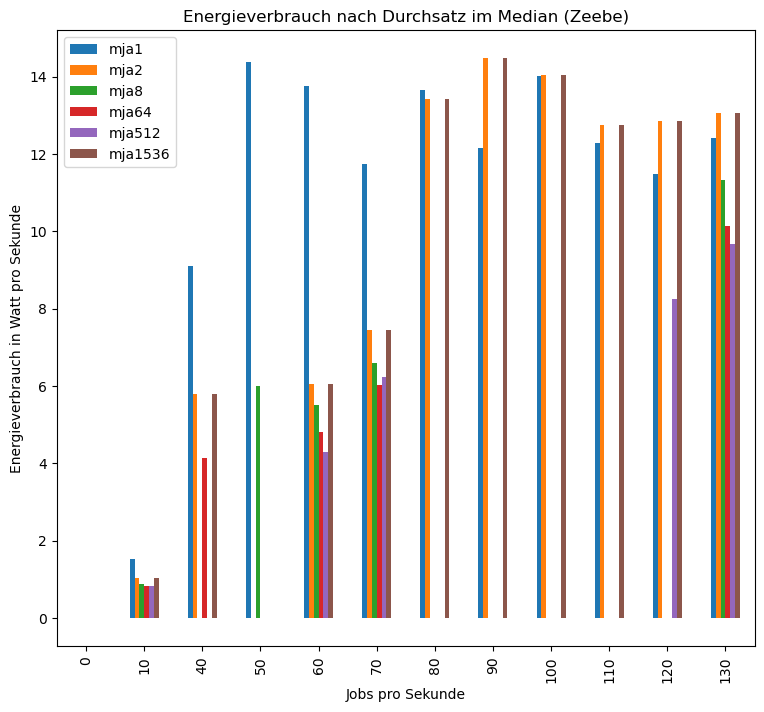

In [32]:
hml_median.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Worker)", ylabel=labels['power'], xlabel=labels['throughput'])
hml_median_zeebe.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Zeebe)", ylabel=labels['power'], xlabel=labels['throughput'])

### Job-Aktivierung

In [33]:
sorted_8.columns

Index(['worker_power', 'zeebe_power', 'jobs_started', 'jobs_finished',
       'jobs_open', 'grpc_activation_ok', 'grpc_activation_exhausted',
       'grpc_activation_total', 'grpc_completion_ok', 'zeebe_job_creation',
       'zeebe_job_completion', 'worker_power_no_idle', 'worker_power_idle',
       'zeebe_power_no_idle', 'zeebe_power_idle',
       'worker_power_per_job_no_idle', 'zeebe_power_per_job_no_idle'],
      dtype='object')

In [34]:
SORT_BY='jobs_started'
SORTED_COLUMN='grpc_activation_ok'

job_Activation_buckets, job_Activation_labels = create_buckets(all_sorted, SORT_BY, 10)
print(job_Activation_buckets)


activation_over_throughput_8_zeebe = filter_outliers_iqr(group_by_bucket(sorted_8, SORT_BY, SORTED_COLUMN, job_Activation_buckets)).dropna(axis=1, thresh=10)
activation_over_throughput_64_zeebe = filter_outliers_iqr(group_by_bucket(sorted_64, SORT_BY, SORTED_COLUMN, job_Activation_buckets)).dropna(axis=1, thresh=10)
activation_over_throughput_512_zeebe = filter_outliers_iqr(group_by_bucket(sorted_512, SORT_BY, SORTED_COLUMN, job_Activation_buckets)).dropna(axis=1, thresh=10)

hml_median_zeebe_activation = pd.DataFrame()
hml_median_zeebe_activation['mja8'] = activation_over_throughput_8_zeebe.median()
hml_median_zeebe_activation['mja64'] = activation_over_throughput_64_zeebe.median()
hml_median_zeebe_activation['mja512'] = activation_over_throughput_512_zeebe.median()

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260]


<Axes: title={'center': 'Jobaktivierungen nach Durchsatz im Median (Zeebe)'}, xlabel='Jobs pro Sekunde', ylabel='Job-Aktivierungen pro Sekunde'>

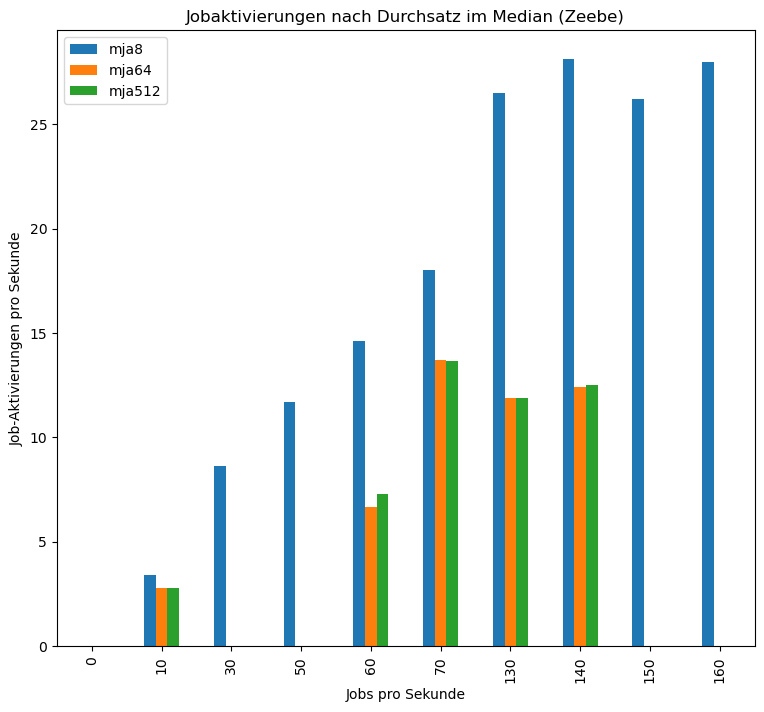

In [35]:
# hml_median.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch nach Durchsatz im Median (Worker)", ylabel=labels['power'], xlabel=labels['throughput'])
hml_median_zeebe_activation.plot(kind='bar', rot=90, figsize=figsize, title="Jobaktivierungen nach Durchsatz im Median (Zeebe)", ylabel="Job-Aktivierungen pro Sekunde", xlabel=labels['throughput'])

In [36]:
SORT_BY='jobs_finished'
SORTED_COLUMN_WORKER='worker_power_per_job_no_idle'
SORTED_COLUMN_ZEEBE='zeebe_power_per_job_no_idle'

power_per_job_1_zeebe = filter_outliers_iqr(group_by_bucket(sorted_1, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_2_zeebe = filter_outliers_iqr(group_by_bucket(sorted_2, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_8_zeebe = filter_outliers_iqr(group_by_bucket(sorted_8, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_64_zeebe = filter_outliers_iqr(group_by_bucket(sorted_64, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_512_zeebe = filter_outliers_iqr(group_by_bucket(sorted_512, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_1536_zeebe = filter_outliers_iqr(group_by_bucket(sorted_1536, SORT_BY, SORTED_COLUMN_ZEEBE, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)

hml_median_zeebe_per_job = pd.DataFrame()
hml_median_zeebe_per_job['mja1'] = power_per_job_1_zeebe.median()
hml_median_zeebe_per_job['mja2'] = power_per_job_2_zeebe.median()
hml_median_zeebe_per_job['mja8'] = power_per_job_8_zeebe.median()
hml_median_zeebe_per_job['mja64'] = power_per_job_64_zeebe.median()
hml_median_zeebe_per_job['mja512'] = power_per_job_512_zeebe.median()
hml_median_zeebe_per_job['mja1536'] = power_per_job_1536_zeebe.median()

power_per_job_1_worker = filter_outliers_iqr(group_by_bucket(sorted_1, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_2_worker = filter_outliers_iqr(group_by_bucket(sorted_2, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_1536_worker = filter_outliers_iqr(group_by_bucket(sorted_1536, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_8_worker = filter_outliers_iqr(group_by_bucket(sorted_8, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_64_worker = filter_outliers_iqr(group_by_bucket(sorted_64, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)
power_per_job_512_worker = filter_outliers_iqr(group_by_bucket(sorted_512, SORT_BY, SORTED_COLUMN_WORKER, buckets)).dropna(axis=1, thresh=BUCKET_MINIMUM)

hml_median_worker_per_job = pd.DataFrame()
hml_median_worker_per_job['mja1'] = power_per_job_1_worker.median()
hml_median_worker_per_job['mja2'] = power_per_job_2_worker.median()
hml_median_worker_per_job['mja8'] = power_per_job_8_worker.median()
hml_median_worker_per_job['mja64'] = power_per_job_64_worker.median()
hml_median_worker_per_job['mja512'] = power_per_job_512_worker.median()
hml_median_worker_per_job['mja1536'] = power_per_job_1536_worker.median()

/home/jabowski/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jabowski/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jabowski/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jabowski/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jabowski/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/jabowski/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = s

<Axes: title={'center': 'Energieverbrauch pro Job nach Durchsatz im Median (Zeebe)'}, xlabel='Jobs pro Sekunde', ylabel='Energieverbrauch in Watt pro Sekunde'>

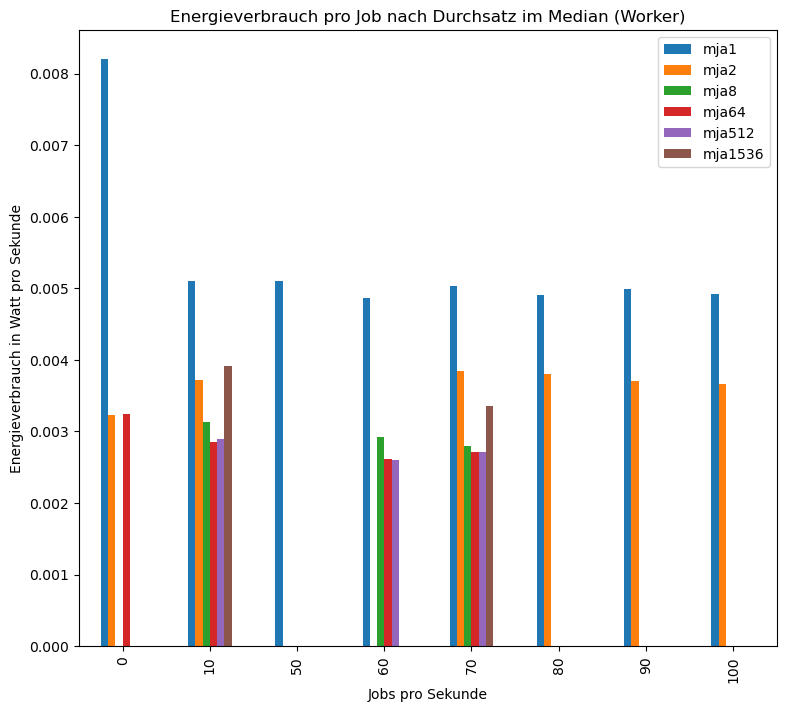

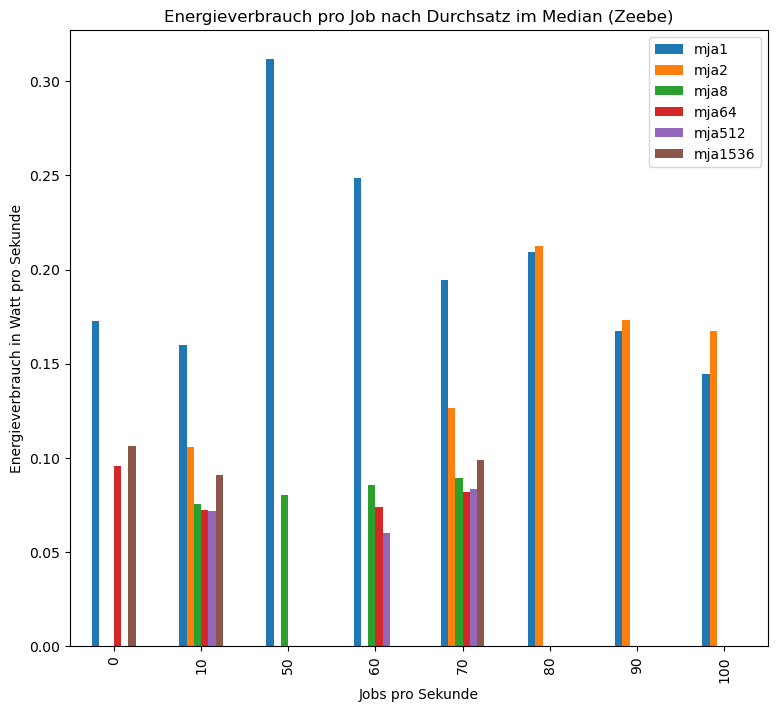

In [37]:
hml_median_worker_per_job.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch pro Job nach Durchsatz im Median (Worker)", ylabel=labels['power'], xlabel=labels['throughput'])
hml_median_zeebe_per_job.plot(kind='bar', rot=90, figsize=figsize, title="Energieverbrauch pro Job nach Durchsatz im Median (Zeebe)", ylabel=labels['power'], xlabel=labels['throughput'])

# Ansatz 2: Energie und Job-Summen

In [38]:
cap_no_idle

,worker_power,zeebe_power,jobs_started,jobs_finished,jobs_open,grpc_activation_ok,grpc_activation_exhausted,grpc_activation_total,grpc_completion_ok,zeebe_job_creation,zeebe_job_completion,worker_power_no_idle,worker_power_idle,zeebe_power_no_idle,zeebe_power_idle,worker_power_per_job_no_idle,zeebe_power_per_job_no_idle
Time,,,,,,,,,,,,,,,,,
2024-02-18 20:30:00,0.2655,0.7390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00070,0.26480,-0.00705,0.74605,inf,-inf
2024-02-18 20:30:10,0.1958,0.4561,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00230,0.19810,-0.01340,0.46950,-inf,-inf
2024-02-18 20:30:20,0.1958,0.6270,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.00230,0.19810,0.06180,0.56520,-inf,inf
2024-02-18 20:30:30,0.9477,0.7529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.68290,0.26480,0.00685,0.74605,inf,inf
2024-02-18 20:30:40,0.3976,0.4526,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.19950,0.19810,-0.01690,0.46950,inf,-inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-18 06:59:20,0.1941,0.4965,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.19230,0.38640,-0.06400,0.56050,NaN,NaN
2024-02-18 06:59:30,0.2658,0.7499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00100,0.26480,0.01080,0.73910,inf,inf
2024-02-18 06:59:40,0.1991,0.4632,NaN,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,-0.18825,0.38735,-0.02430,0.48750,NaN,NaN


<Axes: xlabel='Time', ylabel='gRPC-Calls ActivateJobs (erfolgreich)'>

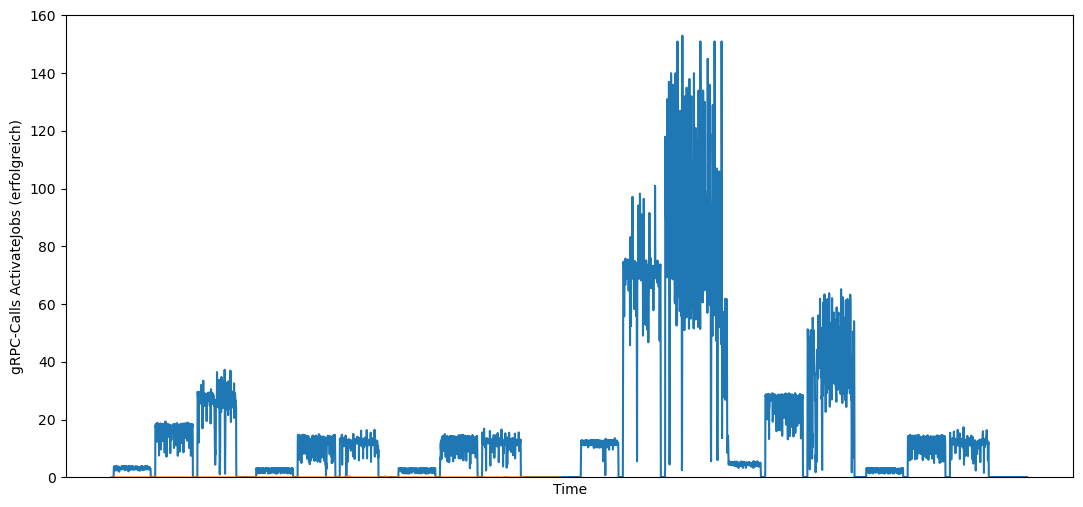

In [39]:
cap_no_idle['grpc_activation_ok'].plot(figsize=[20,6], ylim=[0,160])
completion_and_power_extension['grpc_activation_exhausted'].dropna().plot(figsize=[13,6], ylim=[0,160], ylabel="gRPC-Calls ActivateJobs (erfolgreich)",xticks=[])

In [40]:
AMOUNT_OF_JOBS_LOW = 2 * 90 * 8 * 20 # Process instances * iterations per instance * number of service tasks per iteration * number of runs in measurement
AMOUNT_OF_JOBS_MED = 12 * 90 * 8 * 20 # Process instances * iterations per instance * number of service tasks per iteration * number of runs in measurement
AMOUNT_OF_JOBS_HIGH = 24 * 90 * 8 * 20 # Process instances * iterations per instance * number of service tasks per iteration * number of runs in measurement

# quick hard-code fix, sorry
theoretical_no_of_jobs_list = [
    AMOUNT_OF_JOBS_LOW,
    AMOUNT_OF_JOBS_LOW,
    AMOUNT_OF_JOBS_LOW,
    AMOUNT_OF_JOBS_LOW,
    AMOUNT_OF_JOBS_LOW,
    AMOUNT_OF_JOBS_LOW,
    AMOUNT_OF_JOBS_MED, 
    AMOUNT_OF_JOBS_MED, 
    AMOUNT_OF_JOBS_MED, 
    AMOUNT_OF_JOBS_MED, 
    AMOUNT_OF_JOBS_MED, 
    AMOUNT_OF_JOBS_MED, 
    AMOUNT_OF_JOBS_HIGH,
    AMOUNT_OF_JOBS_HIGH,
    AMOUNT_OF_JOBS_HIGH,
    AMOUNT_OF_JOBS_HIGH,
    AMOUNT_OF_JOBS_HIGH,
    AMOUNT_OF_JOBS_HIGH,
]


theoretical_amt_of_jobs = pd.Series(theoretical_no_of_jobs_list)

In [41]:
# base
LOAD_STAGE_STARTS_8 = [0,20,40]
LOAD_STAGE_STARTS_64 = [60,80,100]
LOAD_STAGE_STARTS_512 = [120,160,180]

# extended
LOAD_STAGE_STARTS_1 = [180,200,220]
LOAD_STAGE_STARTS_2 = [240,260,280]
LOAD_STAGE_STARTS_1536 = [300,320,340]

def create_stage_sum(df, start_log_line, end_log_line, start_times= start_times):
    
    if end_log_line == -1: # end of measurement is not in logs
        temp = df.loc[start_times[start_log_line]:,:]
    else:
        temp = df.loc[start_times[start_log_line]:start_times[end_log_line],:]

    # Keep only rows with throughput > 0
    temp = temp[temp['grpc_completion_ok'] > 0]

    temp_sums = temp[['worker_power_no_idle','zeebe_power_no_idle','worker_power','zeebe_power','jobs_started','jobs_finished','grpc_completion_ok', 'grpc_activation_ok']].sum(axis='index')
    temp_sums['jobs_started'] = temp_sums['jobs_started'] * 10
    temp_sums['jobs_finished'] = temp_sums['jobs_finished'] * 10
    temp_sums['grpc_completion_ok'] = temp_sums['grpc_completion_ok'] * 10
    temp_sums['grpc_activation_ok'] = temp_sums['grpc_activation_ok'] * 10
    temp_sums['power_per_job_worker_total'] = temp_sums['worker_power'] / temp_sums['jobs_finished']
    temp_sums['power_per_job_zeebe_total'] = temp_sums['zeebe_power'] / temp_sums['jobs_finished']
    temp_sums['power_per_job_worker_no_idle'] = temp_sums['worker_power_no_idle'] / temp_sums['jobs_finished']
    temp_sums['power_per_job_zeebe_no_idle'] = temp_sums['zeebe_power_no_idle'] / temp_sums['jobs_finished']
    temp_sums['time'] = len(temp.index) / 6
    temp_sums['mean_finished_jobs_per_second'] = temp_sums['jobs_finished'] / len(temp.index) / 10
    temp_sums['mean_grpc_activation_per_second'] = temp_sums['grpc_activation_ok'] / len(temp.index) / 10

    return temp_sums

sums = pd.DataFrame()

#Base
sums['stage_1_l'] = create_stage_sum(cap_no_idle, 180 , 200) # Extension
sums['stage_2_l'] = create_stage_sum(cap_no_idle, 240, 260) # Extension
sums['stage_8_l'] = create_stage_sum(cap_no_idle, 0, 20)
sums['stage_64_l'] = create_stage_sum(cap_no_idle, 60, 80)
sums['stage_512_l'] = create_stage_sum(cap_no_idle, 120, 140)
sums['stage_1536_l'] = create_stage_sum(cap_no_idle, 300, 320) # Extension
sums['stage_1_m'] = create_stage_sum(cap_no_idle, 200, 220) # Extension
sums['stage_2_m'] = create_stage_sum(cap_no_idle, 260, 280) # Extension
sums['stage_8_m'] = create_stage_sum(cap_no_idle, 20, 40)
sums['stage_64_m'] = create_stage_sum(cap_no_idle, 80, 100)
sums['stage_512_m'] = create_stage_sum(cap_no_idle, 140, 160)
sums['stage_1536_m'] = create_stage_sum(cap_no_idle, 320, 340) # Extension
sums['stage_1_h'] = create_stage_sum(cap_no_idle, 220, 240) # Extension
sums['stage_2_h'] = create_stage_sum(cap_no_idle, 280, 300) # Extension
sums['stage_8_h'] = create_stage_sum(cap_no_idle, 40, 60)
sums['stage_64_h'] = create_stage_sum(cap_no_idle, 100, 120)
sums['stage_512_h'] = create_stage_sum(cap_no_idle, 160, 180)
sums['stage_1536_h'] = create_stage_sum(cap_no_idle, 340, -1) # Extension

sums_T = sums.T

sums

,stage_1_l,stage_2_l,stage_8_l,stage_64_l,stage_512_l,stage_1536_l,stage_1_m,stage_2_m,stage_8_m,stage_64_m,stage_512_m,stage_1536_m,stage_1_h,stage_2_h,stage_8_h,stage_64_h,stage_512_h,stage_1536_h
worker_power_no_idle,1.949450,-8.780650,23.081000,25.059000,26.147600,-2.628700,47.501450,25.287450,54.839800,52.433600,50.553000,21.408450,106.941200,67.706850,96.670600,89.119500,91.207000,57.502450
zeebe_power_no_idle,379.976800,583.436400,219.054350,207.102050,204.759650,223.752300,2740.958200,1825.711300,1622.005750,1432.396900,1476.947050,1488.989200,5180.360500,3753.582800,2742.152250,2426.616300,2420.308050,2420.478600
worker_power,87.497900,75.606700,76.622000,78.600000,79.688600,81.106500,133.436300,111.100700,109.306600,106.635600,105.019800,106.956900,239.875600,174.412700,152.855600,144.841600,147.193900,145.779200
zeebe_power,527.006500,728.930600,363.295100,351.342800,349.000400,368.019900,2888.548400,1973.480100,1768.773300,1578.418400,1623.714600,1636.018900,5409.109300,3936.915000,2893.516000,2576.668800,2571.106600,2572.382100
jobs_started,9410.000000,18910.000000,27960.000000,27810.000000,27930.000000,9330.000000,57100.000000,57740.000000,173970.000000,172490.000000,173790.000000,58380.000000,108030.000000,110370.000000,349190.000000,349820.000000,347570.000000,116580.000000
jobs_finished,28210.000000,57100.000000,27790.000000,27810.000000,27890.000000,27830.000000,173580.000000,173570.000000,173630.000000,172000.000000,173630.000000,173640.000000,324480.000000,348220.000000,348790.000000,348880.000000,346590.000000,348720.000000
grpc_completion_ok,29120.000000,58690.000000,29120.000000,29120.000000,29120.000000,29120.000000,174720.000000,174720.000000,174720.000000,173262.000000,174720.000000,174720.000000,321434.000000,348843.000000,348792.000000,349554.000000,346703.000000,348823.000000
grpc_activation_ok,29139.000000,21298.000000,8078.000000,6157.000000,5994.000000,6233.000000,174914.000000,66284.000000,42135.000000,29168.000000,30677.000000,31619.000000,313671.000000,116828.000000,65437.000000,29912.000000,30398.000000,29913.000000
power_per_job_worker_total,0.003102,0.001324,0.002757,0.002826,0.002857,0.002914,0.000769,0.000640,0.000630,0.000620,0.000605,0.000616,0.000739,0.000501,0.000438,0.000415,0.000425,0.000418
power_per_job_zeebe_total,0.018682,0.012766,0.013073,0.012634,0.012513,0.013224,0.016641,0.011370,0.010187,0.009177,0.009352,0.009422,0.016670,0.011306,0.008296,0.007386,0.007418,0.007377


In [42]:
# adjust for varying amount of jobs
print(theoretical_amt_of_jobs) 

sums_T['power_total_adjusted'] = (sums_T['worker_power'] * sums_T['jobs_finished']).div(theoretical_no_of_jobs_list)

0      28800
1      28800
2      28800
3      28800
4      28800
5      28800
6     172800
7     172800
8     172800
9     172800
10    172800
11    172800
12    345600
13    345600
14    345600
15    345600
16    345600
17    345600
dtype: int64


In [43]:
pd.options.display.float_format = '{:.2f}'.format
sums_T




,worker_power_no_idle,zeebe_power_no_idle,worker_power,zeebe_power,jobs_started,jobs_finished,grpc_completion_ok,grpc_activation_ok,power_per_job_worker_total,power_per_job_zeebe_total,power_per_job_worker_no_idle,power_per_job_zeebe_no_idle,time,mean_finished_jobs_per_second,mean_grpc_activation_per_second,power_total_adjusted
stage_1_l,1.95,379.98,87.50,527.01,9410.00,28210.00,29120.00,29139.00,0.00,0.02,0.00,0.01,41.17,11.42,11.80,85.71
stage_2_l,-8.78,583.44,75.61,728.93,18910.00,57100.00,58690.00,21298.00,0.00,0.01,-0.00,0.01,40.67,23.40,8.73,149.90
stage_8_l,23.08,219.05,76.62,363.30,27960.00,27790.00,29120.00,8078.00,0.00,0.01,0.00,0.01,40.50,11.44,3.32,73.93
stage_64_l,25.06,207.10,78.60,351.34,27810.00,27810.00,29120.00,6157.00,0.00,0.01,0.00,0.01,40.50,11.44,2.53,75.90
stage_512_l,26.15,204.76,79.69,349.00,27930.00,27890.00,29120.00,5994.00,0.00,0.01,0.00,0.01,40.50,11.48,2.47,77.17
stage_1536_l,-2.63,223.75,81.11,368.02,9330.00,27830.00,29120.00,6233.00,0.00,0.01,-0.00,0.01,40.33,11.50,2.58,78.37
stage_1_m,47.50,2740.96,133.44,2888.55,57100.00,173580.00,174720.00,174914.00,0.00,0.02,0.00,0.02,41.33,69.99,70.53,134.04
stage_2_m,25.29,1825.71,111.10,1973.48,57740.00,173570.00,174720.00,66284.00,0.00,0.01,0.00,0.01,41.33,69.99,26.73,111.60
stage_8_m,54.84,1622.01,109.31,1768.77,173970.00,173630.00,174720.00,42135.00,0.00,0.01,0.00,0.01,41.17,70.30,17.06,109.83
stage_64_m,52.43,1432.40,106.64,1578.42,172490.00,172000.00,173262.00,29168.00,0.00,0.01,0.00,0.01,41.00,69.92,11.86,106.14


<Axes: >

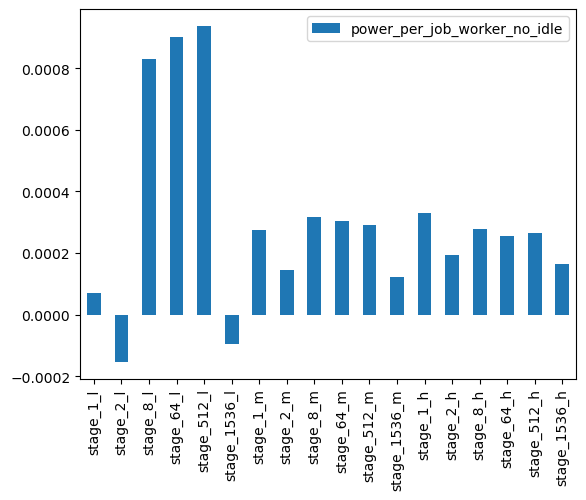

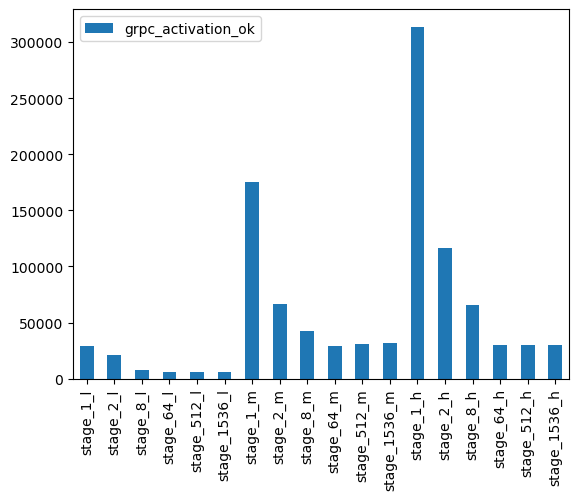

In [44]:
sums_T[['power_per_job_worker_no_idle']].plot(kind='bar', stacked=True)
sums_T[['grpc_activation_ok']].plot(kind='bar')

<Axes: >

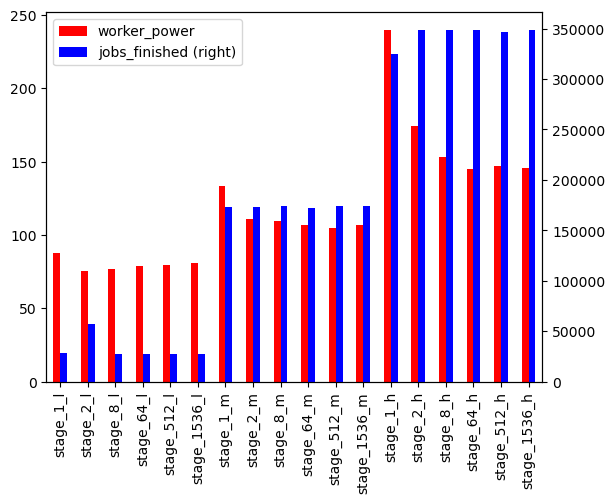

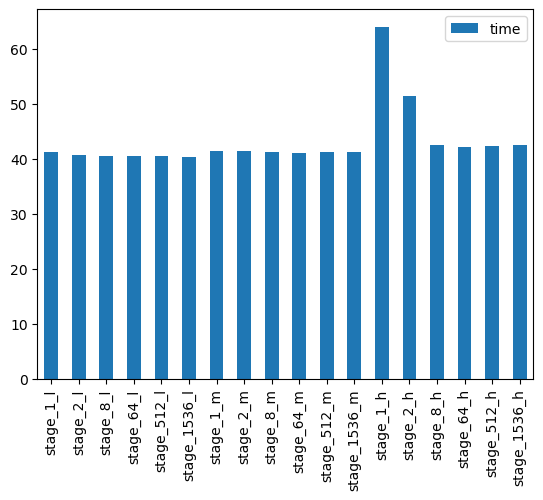

In [45]:
r = '#ff0000'
g = '#00ff00'
b = '#0000ff'

sums_T[['worker_power', 'jobs_finished']].plot(kind='bar', color=[ 
        r,b,r,r,r,r,
        g,g,g,g,g,g,
        b,b,b,b,b,b
        ],
        secondary_y='jobs_finished')

sums_T[['time']].plot(kind='bar')

### Vergleichstabelle anfertigen

In [46]:
pd.options.display.float_format = '{:.1f}%'.format

#### Gesamtverbrauch Grid

In [47]:
diff = pd.DataFrame(sums_T['power_total_adjusted'].to_numpy().reshape(3,6), columns=['1','2', '8','64', '512', '1536'], index=['l', 'm', 'h'])

# .to_numeric(diff, errors='coerce')

ratio_total = diff.div(diff['64'], axis=0) * 100

ratio_total

,1,2,8,64,512,1536
l,112.9%,197.5%,97.4%,100.0%,101.7%,103.3%
m,126.3%,105.1%,103.5%,100.0%,99.4%,101.3%
h,154.0%,120.2%,105.5%,100.0%,101.0%,100.6%


#### Verbrauch pro Worker ohne Idle Grid

In [48]:
diff = pd.DataFrame(sums_T['power_per_job_worker_no_idle'].to_numpy().reshape(3,6), columns=['1','2', '8','64', '512', '1536'], index=['l', 'm', 'h'])

# .to_numeric(diff, errors='coerce')

ratio_per_job = diff.div(diff['64'], axis=0) * 100

# ratio_per_job

#### Verbrauch pro Worker inkl. Idle Grid

In [49]:
diff = pd.DataFrame(sums_T['power_per_job_worker_total'].to_numpy().reshape(3,6), columns=['1','2', '8','64', '512', '1536'], index=['l', 'm', 'h'])

# .to_numeric(diff, errors='coerce')

ratio_total = diff.div(diff['64'], axis=0) * 100

ratio_total

,1,2,8,64,512,1536
l,109.7%,46.8%,97.6%,100.0%,101.1%,103.1%
m,124.0%,103.2%,101.5%,100.0%,97.6%,99.4%
h,178.1%,120.6%,105.6%,100.0%,102.3%,100.7%


,1,2,8,64,512,1536
l,473.3%,345.9%,131.2%,100.0%,97.4%,101.2%
m,599.7%,227.2%,144.5%,100.0%,105.2%,108.4%
h,1048.6%,390.6%,218.8%,100.0%,101.6%,100.0%


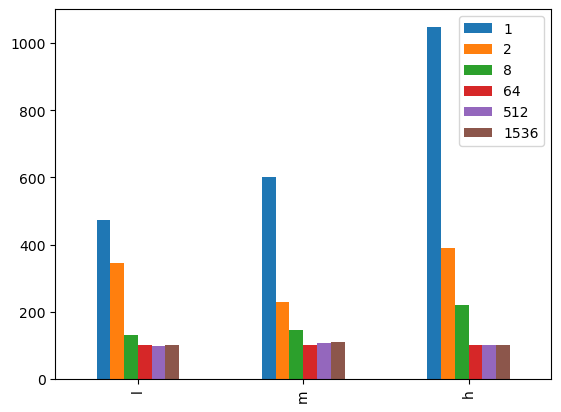

In [50]:
diff = pd.DataFrame(sums_T['grpc_activation_ok'].to_numpy().reshape(3,6), columns=['1','2', '8','64', '512', '1536'], index=['l', 'm', 'h'])

# .to_numeric(diff, errors='coerce')

ratio_grpc_activation = diff.div(diff['64'], axis=0) * 100

ratio_grpc_activation.plot(kind='bar')
ratio_grpc_activation

### Bearbeitungsdauer

In [51]:
clean_sums = sums.copy()
clean_sums[['stage_2_l', 'stage_1_h', 'stage_2_h']] = np.NaN
clean_sums_T = clean_sums.T

clean_sums_indicators = pd.DataFrame()


print(clean_sums_T['time'].mean())
print(clean_sums_T['time'].std())

41.31111111111111
0.7423329448826861


964.978519379845
0.19174905554978097


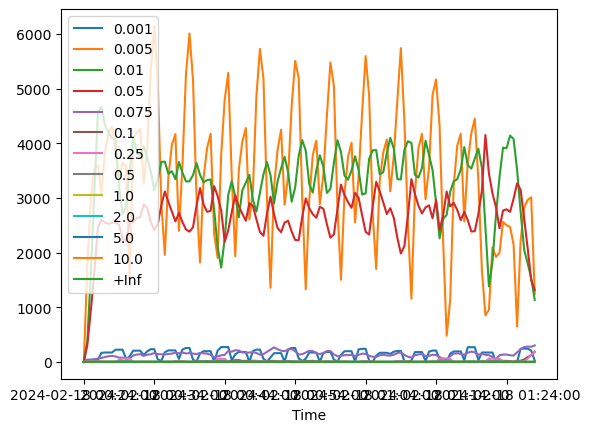

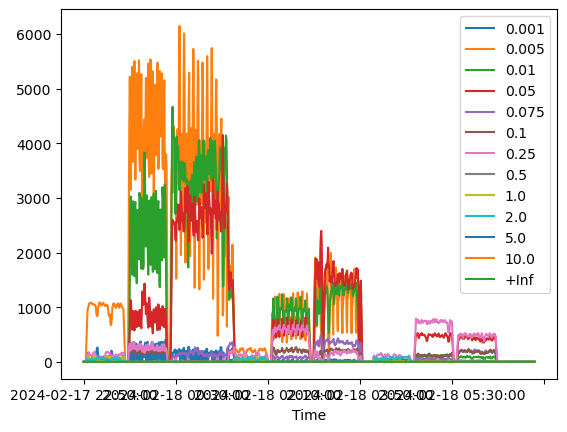

In [52]:
# grpc Latency



index_start_1h = start_times_extended[40]
index_end_1h = start_times_extended[60]
CUTOFF_LATENCY = '0.25'


high_latency = zeebe_latency_extension.loc[:,:]
high_latency_l1 = zeebe_latency_extension.loc[index_start_1h:index_end_1h,:]
high_latency_l1.plot()
high_latency.plot()

print(high_latency_l1.sum(axis=1).sum(axis=0) / len(high_latency_l1.index) / 10)
print(zeebe_latency_extension.mean(axis=1).mean(axis=0) / len(high_latency_l1.index) / 10)



In [53]:
finished_jobs_grid = pd.DataFrame(clean_sums_T['jobs_finished'].to_numpy().reshape(3,6), columns=['1','2', '8','64', '512', '1536'], index=['l', 'm', 'h'])

finished_jobs_indicators = pd.DataFrame([
    finished_jobs_grid.median(axis=1), 
    finished_jobs_grid.std(axis=1),
    finished_jobs_grid.std(axis=1) / finished_jobs_grid.median(axis=1) * 100
    ],
    index= ['median', 'std', 'std_in_percent']
    )

finished_jobs_indicators

,l,m,h
median,27830.0%,173605.0%,348755.0%
std,174.0%,657.9%,1105.3%
std_in_percent,0.6%,0.4%,0.3%


In [54]:
# Vergleich gRPC JobActivation

activation_ok_grid = pd.DataFrame(sums_T['grpc_activation_ok'].to_numpy().reshape(3,6), columns=['1','2', '8','64', '512', '1536'], index=['l', 'm', 'h'])
activation_ok_grid_percent = activation_ok_grid.div(activation_ok_grid['64'], axis=0) * 100

activation_ok_grid_percent

,1,2,8,64,512,1536
l,473.3%,345.9%,131.2%,100.0%,97.4%,101.2%
m,599.7%,227.2%,144.5%,100.0%,105.2%,108.4%
h,1048.6%,390.6%,218.8%,100.0%,101.6%,100.0%
